# Analysis of the Mirex dataset

In this notebook, we analyze the results from FACTM for the Mirex dataset. The following data tables, used to generate Figures 5, 6, B.6, and B.7, as well as a plot (Figure B.5), are created in the order given below::

 - mirex_eta_mu_class.csv
 - Figure B.5 - wordclouds - up to a random seed
 - mirex_topics_sentiment.csv
 - mirex_pvaluesMWtest_factors_rotated_classes.csv
 - mirex_pvaluesMWtest_factors_classes.csv
 - mirex_weights_rotated.csv
 - mirex_factors_classes.csv
 - mirex_rotated_factors_classes.csv

The files containing the model and input are too large to be stored on GitHub. If needed, they will be made available.

## Packages

In [ ]:
import sys
from tqdm import tqdm
import dill
sys.path.append('factm')
from model_class import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import f_oneway
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import mannwhitneyu

# for rotations
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


In [2]:
from wordcloud import WordCloud
from wordcloud import (WordCloud, get_single_color_func)

# the code below is from the wordcloud package documentation
# and is used to create word clouds with words colored by positive or negative sentiment
# (https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html)

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

## Load data and the model

In [ ]:
genres = pd.read_csv('genres_dummy.csv', index_col=0)
lyrics_exist = pd.read_csv('lyrics_exist.csv')
genres = genres.loc[lyrics_exist['exists'],:]

In [4]:
most_popular_genres = ['alternative', 'blues', 'country', 'pop', 'rock']

In [ ]:
with open('factm_input_info.pkl', "rb") as input_file:
    [feature_names, classes, categories, vocab] = dill.load(input_file)
feature_names.append(['topic_'+str(i) for i in range(10)])
categories_names, categories_int = np.unique(categories, return_inverse=True)

In [ ]:
info_sentiment = pd.read_csv('lyrics_vocab_description_577.csv', index_col=0)

In [ ]:
# differen feature names format 
# with open('data/input/FACTM_input_sentences-lines_SMEL_577_names.pkl', "rb") as input_file:
#     feature_names = dill.load(input_file)

In [ ]:
# load model
input_version = 'sentences-lines_SMEL_577'

with open('factm_'+input_version+'.pkl', "rb") as input_file:
    factm = dill.load(input_file)

In [ ]:
# load input to the model
with open('FACTM_input_'+input_version+'.pkl', "rb") as input_file:
    factm_input = dill.load(input_file)

In [11]:
L = factm.ctm_list['M4'].L
factors = factm.get_pe_latent_factors()

## FACTM output

### Table: Mu_FA, Eta, probabilities vs classes

 - mirex_eta_mu_class.csv

In [22]:
df_info_tmp = pd.DataFrame(factm.get_pe_eta(4))
df_info_tmp.columns = ['Topic '+str(i+1) for i in range(10)]
df_info_tmp['sample_id'] = np.arange(0, factm.get_pe_eta(4).shape[0], 1)
df_info_tmp['class'] = classes
df_info_eta = pd.melt(df_info_tmp, id_vars=['sample_id', 'class'], value_name='eta', var_name='topic')

In [23]:
df_info_tmp = pd.DataFrame(factm.get_pe_muFA(4))
df_info_tmp.columns = ['Topic '+str(i+1) for i in range(10)]
df_info_tmp['sample_id'] = np.arange(0, factm.get_pe_eta(4).shape[0], 1)
df_info_tmp['class'] = classes
df_info_muFA = pd.melt(df_info_tmp, id_vars=['sample_id', 'class'], value_name='muFA', var_name='topic')

In [24]:
df_info_tmp = pd.DataFrame(factm.get_pe_eta_probabilities_of_topics(4))
df_info_tmp.columns = ['Topic '+str(i+1) for i in range(10)]
df_info_tmp['sample_id'] = np.arange(0, factm.get_pe_eta(4).shape[0], 1)
df_info_tmp['class'] = classes
df_info_prob = pd.melt(df_info_tmp, id_vars=['sample_id', 'class'], value_name='probabilities', var_name='topic')

In [25]:
df_info = pd.merge(df_info_eta,df_info_muFA)
df_info = pd.merge(df_info,df_info_prob)

In [109]:
# df_info.to_csv('mirex_eta_mu_class.csv')

### Topics - words' sentiment - classes

 - Fig. B6 - wordclouds
 - mirex_topics_sentiment.csv

In [27]:
neg_vocab = info_sentiment['vocab'][info_sentiment['negative'] > 0].tolist()
pos_vocab = info_sentiment['vocab'][info_sentiment['positive'] > 0].tolist()

In [30]:
color_to_words = {
    # words below will be colored with a green single color function
    'red': neg_vocab,
    'green': pos_vocab
}

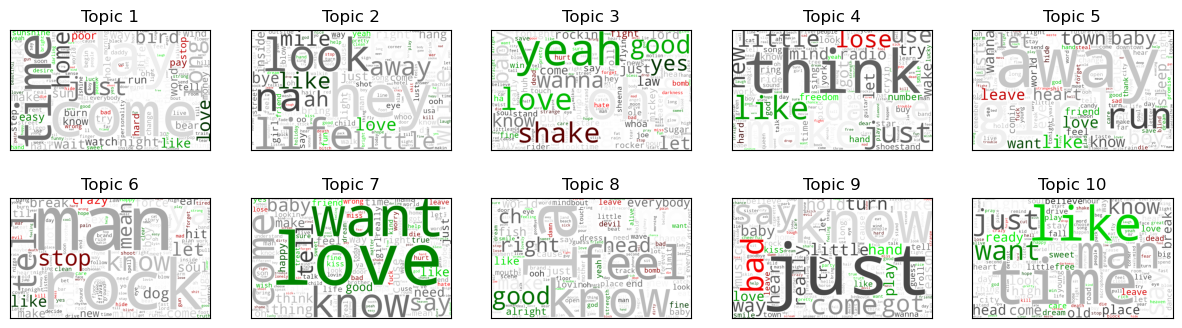

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(15, 4))
for l in range(L):
    topic_l = dict(map(lambda i,j : (i,j), vocab.T[0].tolist(),factm.get_pe_topics(4)[l,:]))
    wordcloud = WordCloud(width=1000, height=600, background_color='white', collocations=False).generate_from_frequencies(topic_l)
    default_color = 'grey'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)
    # Apply our color function
    wordcloud.recolor(color_func=grouped_color_func)
    i = l % 5
    j =  l // 5
    axs[j, i].imshow(wordcloud)
    axs[j, i].get_yaxis().set_ticks([])
    axs[j, i].get_xaxis().set_ticks([])
    axs[j, i].set_title('Topic '+str(l+1))

In [38]:
# positivity-negativity of topics based on fractions of positive/negative words (averaged over topic-word probabilities)
pos = np.dot(factm.get_pe_topics(4), np.array(info_sentiment['positive']))
neg = np.dot(factm.get_pe_topics(4), np.array(info_sentiment['negative']))
df = pd.DataFrame({'topic': ['Topic '+str(i+1) for i in range(10)],
                   'positive': pos,
                   'negative': neg})

In [116]:
# df.to_csv('mirex_topics_sentiment.csv')

### Rotations

 - mirex_pvaluesMWtest_factors_rotated_classes.csv
 - mirex_pvaluesMWtest_factors_classes.csv
 - mirex_weights_rotated.csv
 - mirex_factors_classes.csv
 - mirex_rotated_factors_classes.csv

In [42]:
# functions

def rotation(mat):

    H = mat
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    
    return R

def pvalues_matrix(x, y):

    p1 = x.shape[1]
    p2 = y.shape[1]
    results = np.zeros((p1,p2))

    for i in range(p1):
        for j in range(p2):
            df = pd.DataFrame({
                'y': y[:,j],
                'x': x[:,i]
            })
            df['y'] = df['y'].astype('category')

            model = ols('x ~ y', data = df).fit()
                
            anova_result = sm.stats.anova_lm(model, typ=2)
            
            results[i,j] = anova_result['PR(>F)'][0]
    
    return results

def pvalues_MW_matrix(x, y):

    p1 = x.shape[1]
    p2 = y.shape[1]
    results = np.zeros((p1,p2))

    for i in range(p1):
        for j in range(p2):
            x_tmp = x[~np.isnan(y[:,j]),i]
            y_tmp = y[~np.isnan(y[:,j]),j]

            res_tmp = mannwhitneyu(x_tmp[y_tmp==0], x_tmp[y_tmp==1])
            
            results[i,j] = res_tmp[1]
    
    return results

def Fvalues_matrix(x, y):

    p1 = x.shape[1]
    p2 = y.shape[1]
    results = np.zeros((p1,p2))

    for i in range(p1):
        for j in range(p2):
            df = pd.DataFrame({
                'y': y[:,j],
                'x': x[:,i]
            })
            df['y'] = df['y'].astype('category')

            model = ols('x ~ y', data = df).fit()
                
            anova_result = sm.stats.anova_lm(model, typ=2)
            
            results[i,j] = anova_result['F'][0]
    
    return results

def dependence_matrix(x, y, metric = 'pearson'):

    p1 = x.shape[1]
    p2 = y.shape[1]
    results = np.zeros((p1,p2))

    for i in range(p1):
        for j in range(p2):
            x_tmp = x[~np.isnan(y[:,j]),i]
            y_tmp = y[~np.isnan(y[:,j]),j]

            if metric == 'pearson': 
                results[i,j] = pearsonr(x_tmp, y_tmp)[0]
            if metric == 'spearman':
                results[i,j] = spearmanr(x_tmp, y_tmp)[0]
            if metric == 'Fstatistic':
                df = pd.DataFrame({
                    'y': y[:,j],
                    'x': x[:,i]
                })
                df['y'] = df['y'].astype('category')
                model = ols('x ~ y', data = df).fit() 
                anova_result = sm.stats.anova_lm(model, typ=2)
                results[i,j] = (anova_result['F'][0])
            if metric == 'Fscaled':
                df1 = pd.DataFrame({
                    'y': y_tmp,
                    'x': x_tmp
                })
                df1['y'] = df1['y'].astype('category')
                model1 = ols('x ~ y', data = df1).fit()   
                anova_result1 = sm.stats.anova_lm(model1, typ=2)

                df2 = pd.DataFrame({
                    'y': np.sort(y_tmp),
                    'x': np.sort(x_tmp)
                })
                df2['y'] = df2['y'].astype('category')
                model2 = ols('x ~ y', data = df2).fit()
                anova_result2 = sm.stats.anova_lm(model2, typ=2)
                results[i,j] = anova_result1['F'][0]/anova_result2['F'][0]
            if metric == 'Fscaled2':
                df1 = pd.DataFrame({
                    'y': y_tmp,
                    'x': x_tmp
                })
                df1['y'] = df1['y'].astype('category')
                model1 = ols('x ~ y', data = df1).fit()   
                anova_result1 = sm.stats.anova_lm(model1, typ=2)
                var_x = np.var(x_tmp)*(x_tmp.shape[0] - 2)
                results[i,j] = anova_result1['F'][0]*(var_x/(var_x - 2))
                
            if metric == 'pvalue_transformed':
                df1 = pd.DataFrame({
                    'y': y_tmp,
                    'x': x_tmp
                })
                df1['y'] = df1['y'].astype('category')
                model1 = ols('x ~ y', data = df1).fit()   
                anova_result1 = sm.stats.anova_lm(model1, typ=2)
                pval = anova_result1['PR(>F)'][0]
                pval_transformed = 1 + (1/0.1)*(pval - 0.1)
                results[i,j] = -np.log(pval_transformed)

    return results
 
def beta_matrix(x, y):
    p1 = x.shape[1]
    p2 = y.shape[1]
    results = np.zeros((p1,p2))
    for j in range(p2):
        mod = LogisticRegression(penalty='none', fit_intercept=False)
        x_tmp = x[~np.isnan(y[:,j]),:]
        y_tmp = y[~np.isnan(y[:,j]),j]
        mod.fit(x_tmp, y_tmp)
        results[:,j] = mod.coef_

    return results

def plot_pvals(pval, xticks):
    fig, axarr = plt.subplots(1,3)
    plt1 = axarr[0].imshow(pval, vmin=0, vmax=1)
    axarr[1].imshow(pval< 0.05/100)
    axarr[1].set_xticks(xticks)
    axarr[1].set_title('rejected: '+str(np.sum(pval< 0.05/100))+' ('+str(np.sum(np.diag(pval< 0.05/100)))+')')
    axarr[2].imshow(pval< 0.05)
    axarr[2].set_title('rejected: '+str(np.sum(pval< 0.05))+' ('+str(np.sum(np.diag(pval< 0.05)))+')')
    fig.colorbar(plt1, ax=axarr, location='bottom', shrink=0.5)
    plt.show()

def plot_pvals_sns(pval, factor_ticks, features_ticks):
    fig, axarr = plt.subplots(1,3, figsize=(10,3))
    sns.heatmap(-np.log10(pval.T), yticklabels=features_ticks, xticklabels=factor_ticks, ax=axarr[0]).set_title('-log10(pval)')
    sns.heatmap(pval.T < 0.05/100, yticklabels='', xticklabels=factor_ticks, ax=axarr[1],
                vmin=0, vmax=1).set_title('pval<0.05/100 ['+str(np.sum(pval< 0.05/100))+' ('+str(np.sum(np.diag(pval< 0.05/100)))+')]')
    sns.heatmap(pval.T < 0.05, yticklabels='', xticklabels=factor_ticks, ax=axarr[2],
                vmin=0, vmax=1).set_title('pval<0.05 ['+str(np.sum(pval< 0.05))+' ('+str(np.sum(np.diag(pval< 0.05)))+')]')

def plot_pvals_sns_2(pval, factor_ticks, features_ticks):
    fig, axarr = plt.subplots(1,3, figsize=(10,3))
    sns.heatmap(-np.log10(pval.T), yticklabels=features_ticks, xticklabels=factor_ticks, ax=axarr[0]).set_title('-log10(pval)')
    sns.heatmap(pval.T < 0.05/100, yticklabels='', xticklabels=factor_ticks, ax=axarr[1],
                vmin=0, vmax=1).set_title('pval<0.05/100 ['+str(np.sum(pval< 0.05/100))+']')
    sns.heatmap(pval.T < 0.05, yticklabels='', xticklabels=factor_ticks, ax=axarr[2],
                vmin=0, vmax=1).set_title('pval<0.05 ['+str(np.sum(pval< 0.05))+']')

def run_rotations_plots_outputs(x_rotated, y, factor_names, factor_rotated_names, factor_index, var_names, save=False, num='0'):
    
    y = np.array(y).astype('float')
    dep = dependence_matrix(x_rotated, y, 'pearson')

    rotation_pearson = rotation(dep)
    new_x_pearson = np.dot(rotation_pearson, np.array(x_rotated).T).T

    factor_rotated = pd.DataFrame(new_x_pearson)
    factor_rotated.columns = factor_rotated_names
    factor_rotated.index = factor_index

    # if save:
    #     np.savetxt('rotation_matrix_v'+str(num)+'.txt', rotation_pearson)
    #     factor_rotated.to_csv('factor_matrix_new_v'+str(num)+'.csv')
    
    return factor_rotated, rotation_pearson

In [47]:
classes_dummy = pd.get_dummies(classes)
binary_features = np.hstack((classes_dummy, genres[most_popular_genres]))
binary_features_names = np.concatenate((np.array(['Class 1', 'Class 2','Class 3', 'Class 4','Class 5']),most_popular_genres))

In [45]:
factors_rotated, rotation = run_rotations_plots_outputs(factors, binary_features, factor_names=np.arange(0,10,1),
                            factor_rotated_names=np.arange(0,10,1), factor_index=np.arange(0,factors.shape[0],1),
                            var_names=np.arange(0,10,1))

In [48]:
df_pvalues = pd.DataFrame(pvalues_MW_matrix(np.array(factors_rotated), binary_features))
df_pvalues.index = ['Factor ' + str(i+1) for i in range(10)]
df_pvalues.columns = binary_features_names
# df_pvalues.to_csv('mirex_pvaluesMWtest_factors_rotated_classes.csv')

In [59]:
df_pvalues = pd.DataFrame(pvalues_MW_matrix(factors, binary_features))
df_pvalues.index = ['Factor ' + str(i+1) for i in range(10)]
df_pvalues.columns = binary_features_names
# df_pvalues.to_csv('mirex_pvaluesMWtest_factors_classes.csv')

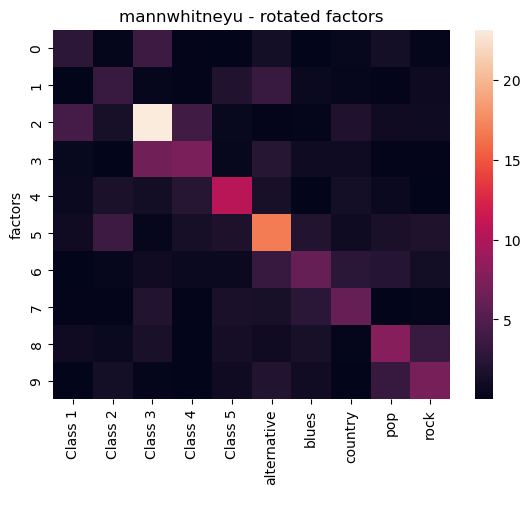

In [50]:
ax = sns.heatmap(-np.log10(pvalues_MW_matrix(np.array(factors_rotated), binary_features)))
ax.set_ylabel('factors')
ax.set_xlabel(' ')
ax.set_xticklabels(binary_features_names, rotation=90)
ax.set_title('mannwhitneyu - rotated factors')
plt.show()

In [ ]:
df_weights = pd.DataFrame()
for i in range(10):
    fn_vec = np.concatenate((feature_names[0], feature_names[1], feature_names[2], feature_names[3]))
    wei_vec = np.concatenate([np.dot(factm.get_pe_loadings_dense(i0), rotation.T)[:,i] for i0 in range(4)])
    vie_vec = np.concatenate([np.repeat(i0, np.dot(factm.get_pe_loadings_dense(i0), rotation.T)[:,i].shape[0]) for i0 in range(4)])
    df_weights_tmp = pd.DataFrame({'factor':i, 'feature_name':fn_vec, 'weight':wei_vec, 'view': vie_vec})
    df_weights = pd.concat([df_weights, df_weights_tmp], ignore_index=True)
# df_weights.to_csv('mirex_weights_rotated.csv')

In [60]:
df_info_tmp = pd.DataFrame(factm.get_pe_latent_factors())
df_info_tmp.columns = ['Factor '+str(i+1) for i in range(10)]
df_info_tmp['sample_id'] = np.arange(0, factm.get_pe_eta(4).shape[0], 1)
df_info_tmp['class'] = classes
df_info = pd.melt(df_info_tmp, id_vars=['sample_id', 'class'], value_name='value', var_name='factor')
# df_info.to_csv('mirex_factors_classes.csv')

In [ ]:
df_info_tmp = pd.DataFrame(np.array(factors_rotated))
df_info_tmp.columns = ['Factor '+str(i+1) for i in range(10)]
df_info_tmp['sample_id'] = np.arange(0, factm.get_pe_eta(4).shape[0], 1)
df_info_tmp['class'] = classes
df_info = pd.melt(df_info_tmp, id_vars=['sample_id', 'class'], value_name='value', var_name='factor')
# df_info.to_csv('factors_rotated_classes.csv')